In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
import cv2
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras import layers, models, utils, callbacks

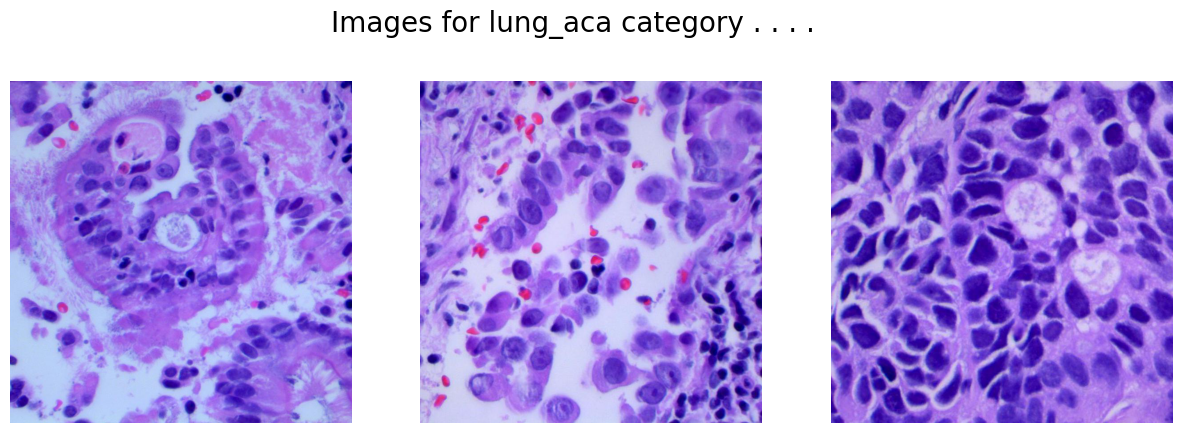

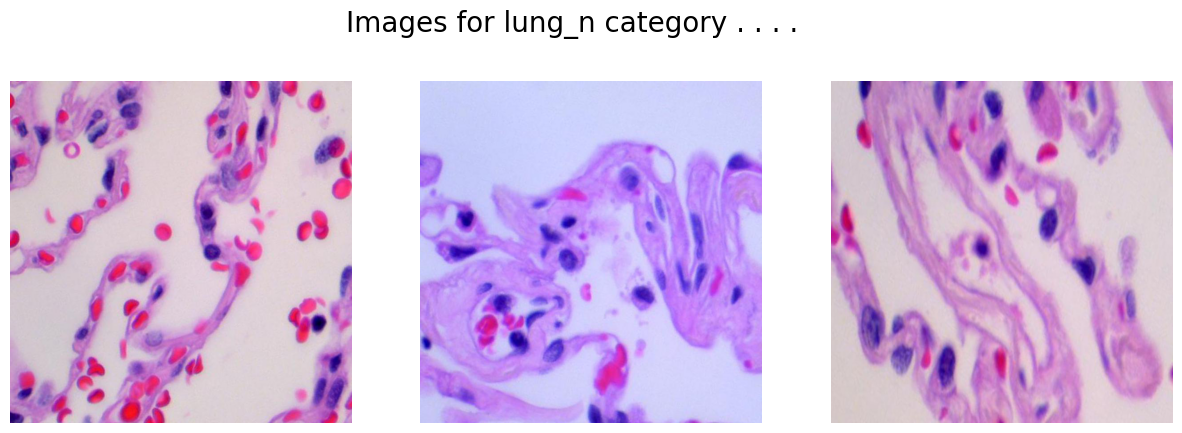

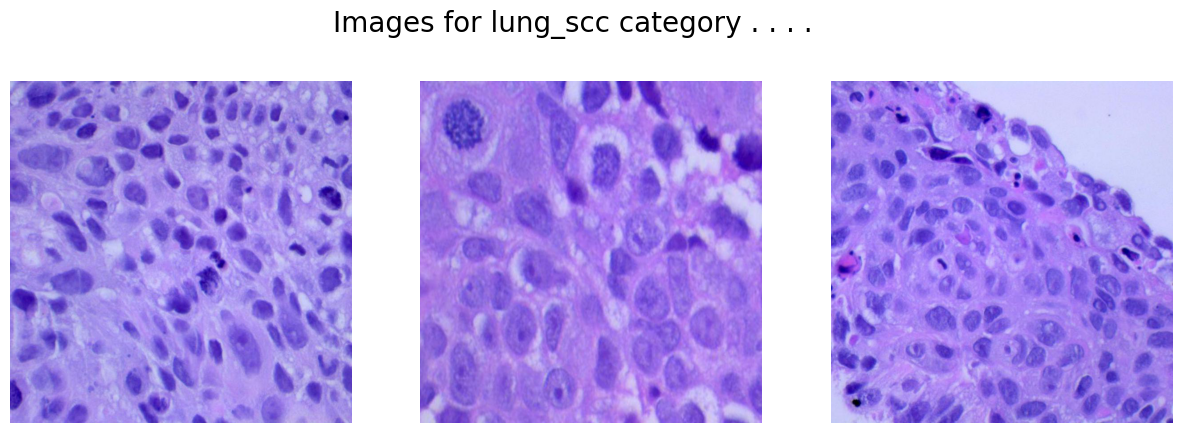

In [2]:


# Constants
IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 64
DATA_PATH = 'C:\\Users\\priya\\Downloads\\lung_image_sets'

# Display some images from each category
classes = os.listdir(DATA_PATH)
for cat in classes:
    image_dir = os.path.join(DATA_PATH, cat)
    images = os.listdir(image_dir)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)

    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(os.path.join(image_dir, images[k])))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()


In [3]:

# Prepare data
X = []
Y = []

for i, cat in enumerate(classes):
    images = glob(os.path.join(DATA_PATH, cat, '*.jpeg'))
    for image in images:
        img = cv2.imread(image)
        if img is not None:
            X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
            Y.append(i)


In [4]:

X = np.asarray(X)
one_hot_encoded_Y = utils.to_categorical(Y, num_classes=len(classes))
X_train, X_val, Y_train, Y_val = train_test_split(X, one_hot_encoded_Y, test_size=SPLIT, random_state=2022)
print(X_train.shape, X_val.shape)


(12000, 256, 256, 3) (3000, 256, 256, 3)


In [8]:

# Build the model
model = models.Sequential([
    layers.Conv2D(filters=32, kernel_size=(5, 5), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3), padding='same'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(len(classes), activation='softmax')
])
model.summary()
utils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_activations=True)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 32, 128)     

AttributeError: module 'pydot' has no attribute 'InvocationException'

In [14]:

# Define callbacks
class myCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') > 0.90:
            print('\nValidation accuracy has reached 90%, stopping training.')
            self.model.stop_training = True

es = callbacks.EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True)
lr = callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, verbose=1)


In [15]:

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Train the model
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, callbacks=[es, lr, myCallback()])
# Save the trained model
model.save('trained_models/my_trained_model.h5')
print("Model saved successfully.")

Epoch 1/10
 75/188 [==========>...................] - ETA: 10:24 - loss: 0.4726 - accuracy: 0.7917

In [ ]:

# Plot the training history
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
plt.show()

# Reload the saved model for prediction
model = load_model('trained_models/my_trained_model.h5')

In [ ]:
# Evaluate the model
Y_pred = model.predict(X_val)
Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)
conf_matrix = metrics.confusion_matrix(Y_val, Y_pred)
print(conf_matrix)
print(metrics.classification_report(Y_val, Y_pred, target_names=classes))

model.save('trained_models/my_trained_model.h5')
